In [17]:
# --- Modeling Setup ---

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Select features and target
df_metrics = pd.read_csv("../data/data_derivatives/features.csv")
df_metrics = df_metrics[df_metrics["SedationLevel"] != 4].copy() #dropping recovery state
features = ["mean_degree", "clustering", "path_length", "small_worldness", "modularity", "global_efficiency"]
target = "SedationLevel"

X = df_metrics[features].copy()
y = df_metrics[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
rf = RandomForestClassifier(
    n_estimators=300,        # still enough trees for stability
    max_depth=8,             # limits overfitting
    min_samples_leaf=4,      # prevents very small terminal nodes
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    oob_score=True           # enables internal cross-validation estimate
)

rf.fit(X_train_scaled, y_train)



,n_estimators,300
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [19]:

print(f"Train accuracy: {rf.score(X_train_scaled, y_train):.2f}")
print(f"Test accuracy: {rf.score(X_test_scaled, y_test):.2f}")
print(f"OOB score: {rf.oob_score_:.2f}")

Train accuracy: 0.85
Test accuracy: 0.33
OOB score: 0.39


In [10]:

# Predictions
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Random Forest Performance:\n")
print(classification_report(y_test, y_pred))

# ROC-AUC
auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Random Forest Performance:

              precision    recall  f1-score   support

    Baseline       0.27      0.20      0.23        20
        Mild       0.11      0.10      0.11        20
    Moderate       0.29      0.45      0.35        20
    Recovery       0.31      0.25      0.28        20

    accuracy                           0.25        80
   macro avg       0.25      0.25      0.24        80
weighted avg       0.25      0.25      0.24        80



ValueError: multi_class must be in ('ovo', 'ovr')

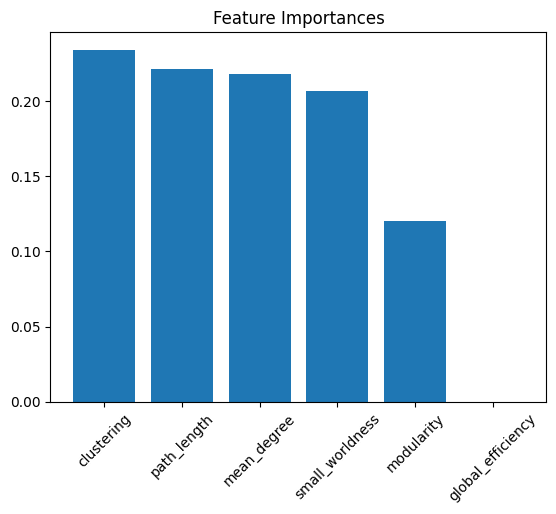

In [6]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), np.array(features)[indices], rotation=45)
plt.title("Feature Importances")
plt.show()

In [22]:
rf_models = {}   # <-- add this to store models
bands = df_metrics["Band"].unique()
band_results = []

for band in bands:
    # Subset data for this band
    band_df = df_metrics[df_metrics["Band"] == band].copy()
    
    # Define features (exclude identifiers and labels)
    features = [
        "mean_degree",
        "clustering",
        "path_length",
        "small_worldness",
        "Propofol_ugL"
    ]
    X = band_df[features]
    y = band_df["SedationLevel"]

    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define Random Forest
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=4,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1,
        oob_score=True
    )

    rf.fit(X_train_scaled, y_train)
    train_acc = rf.score(X_train_scaled, y_train)
    test_acc = rf.score(X_test_scaled, y_test)
    oob_acc = rf.oob_score_

    band_results.append({
        "Band": band,
        "Train_Acc": train_acc,
        "Test_Acc": test_acc,
        "OOB_Acc": oob_acc
    })
    rf_models[band] = rf 

# Convert to DataFrame for easy comparison
band_results_df = pd.DataFrame(band_results)

display(band_results_df.sort_values("Test_Acc", ascending=False))

,Band,Train_Acc,Test_Acc,OOB_Acc
2,alpha,0.937500,0.916667,0.854167
3,beta,0.979167,0.916667,0.895833
0,delta,0.958333,0.833333,0.854167
1,theta,0.979167,0.833333,0.875000
4,gamma,0.979167,0.833333,0.770833


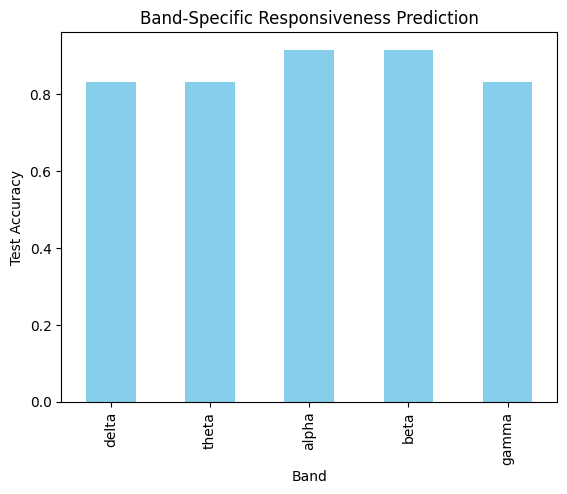

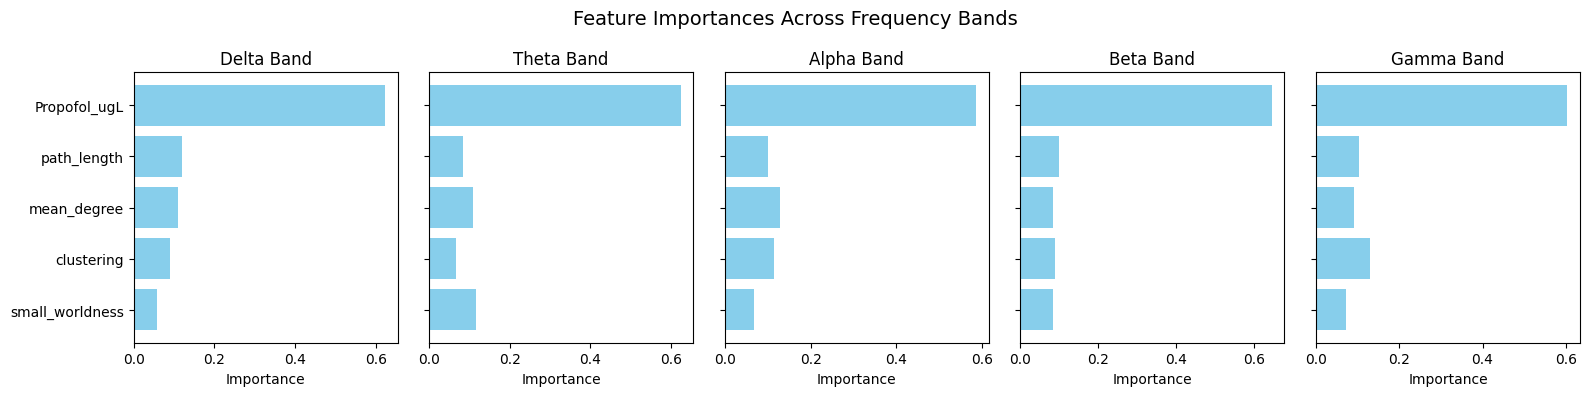

In [23]:
band_results_df.plot(x="Band", y="Test_Acc", kind="bar", color="skyblue", legend=False)
plt.ylabel("Test Accuracy")
plt.title("Band-Specific Responsiveness Prediction")
plt.show()

fig, axes = plt.subplots(1, len(rf_models), figsize=(16, 4), sharey=True)

for i, (band, model) in enumerate(rf_models.items()):
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=True)
    axes[i].barh(importances.index, importances.values, color="skyblue")
    axes[i].set_title(f"{band.capitalize()} Band")
    axes[i].set_xlabel("Importance")

plt.suptitle("Feature Importances Across Frequency Bands", fontsize=14)
plt.tight_layout()
plt.show()